# CMIP6 Regional variable change

**Following steps are included in this script:**

1. Load netCDF files
2. Compute regional variable change
3. Plot change in reional parallel coordinate plots

## Import Packages

In [1]:
# ========== Packages ==========
import sys
import os
import xarray as xr
import pandas as pd
import numpy as np
import dask
from dask.diagnostics import ProgressBar
import importlib
import regionmask

# Define the full path to the data_handling directory and the config file
data_handling_dir = '/work/ch0636/g300115/phd_project/common/src/data_handling'
data_vis_dir = '/work/ch0636/g300115/phd_project/common/src/visualization'
config_dir = '/work/ch0636/g300115/phd_project/common/src'

# Add the directories to sys.path
sys.path.append(data_handling_dir)
sys.path.append(config_dir)
sys.path.append(data_vis_dir)

# Now import the functions from load_preprocessed_data.py and config
import load_data as load_dat
import process_data as pro_dat
import compute_statistics as comp_stats
import colormaps as colmap
import parallel_coordinate_plots as par_coor_plot

from config import BASE_DIR, DEFAULT_MODEL, DEFAULT_VARIABLE, DEFAULT_TEMPORAL_RES, DEFAULT_EXPERIMENT

In [152]:
importlib.reload(load_dat)
importlib.reload(pro_dat)
importlib.reload(comp_stats)
importlib.reload(colmap)
importlib.reload(par_coor_plot)

<module 'parallel_coordinate_plots' from '/work/ch0636/g300115/phd_project/common/src/visualization/parallel_coordinate_plots.py'>

In [284]:
# For plotting
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
plt.rcParams['text.usetex'] = False
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath, amssymb, textcomp}'

# For color map
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm

#Check all possible fonts
import matplotlib.font_manager
from IPython.core.display import HTML

def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

# Set the font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["font.sans-serif"] = ["Nimbus Sans"]

## 1. Load and Preprocess

### 1.1 Load Data

In [4]:
# ========= Define period, models and path ==============
data_state = 'processed'
data_product = 'CMIP6'
experiments = ['historical', 'ssp370']
models = ['BCC-CSM2-MR', 'CESM2', 'CMCC-CM2-SR5', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'CanESM5', 
          'IPSL-CM6A-LR', 'MIROC-ES2L', 'MPI-ESM1-2-LR', 'NorESM2-MM', 'UKESM1-0-LL']

variables=['tas', 'pr', 'vpd', 'evspsbl', 'evapo', 'tran', 'mrro', 'mrso', 'lai', 'gpp', 'wue', 'RX5day', 'gsl'] 
           
# Execute load function with Dask
with ProgressBar():
    ds_dict = dask.compute(load_dat.load_period_mean(BASE_DIR, data_state, data_product, experiments, models, variables, specific_months_or_seasons=None))[0]

Loading 'month' resolution variables ['tas', 'pr', 'vpd', 'evspsbl', 'evapo', 'tran', 'mrro', 'mrso', 'lai', 'gpp', 'wue'] for experiment 'historical'...
Selecting period 1985-2014 for 'month' variables in experiment 'historical'...
Computing period mean for 'month' variables in experiment 'historical'...
Loading 'year' resolution variable 'RX5day' for experiment 'historical'...
Computing period mean for 'year' variable in experiment 'historical'...
Loading 'period_mean' resolution variable 'gsl' for experiment 'historical'...
Merging all datasets for experiment 'historical'...
Loading 'month' resolution variables ['tas', 'pr', 'vpd', 'evspsbl', 'evapo', 'tran', 'mrro', 'mrso', 'lai', 'gpp', 'wue'] for experiment 'ssp370'...
Selecting period 2071-2100 for 'month' variables in experiment 'ssp370'...
Computing period mean for 'month' variables in experiment 'ssp370'...
Loading 'year' resolution variable 'RX5day' for experiment 'ssp370'...
Computing period mean for 'year' variable in expe

### 1.2 Compute Historical BGWS and Ensemble statsitics

In [5]:
ds_dict = pro_dat.compute_bgws(ds_dict)

In [6]:
ds_dict = pro_dat.compute_tbgw(ds_dict)

In [7]:
ds_dict['historical'] = comp_stats.compute_ensemble_statistic(ds_dict['historical'], 'mean')
ds_dict['historical'] = comp_stats.compute_ensemble_statistic(ds_dict['historical'], 'median')

Computed Ensemble mean for all experiments.
Computed Ensemble median for all experiments.


In [8]:
ds_dict['ssp370'] = comp_stats.compute_ensemble_statistic(ds_dict['ssp370'], 'mean')
ds_dict['ssp370'] = comp_stats.compute_ensemble_statistic(ds_dict['ssp370'], 'median')

Computed Ensemble mean for all experiments.
Computed Ensemble median for all experiments.


### 1.3 Compute Changes and Ensemble statsitics

In [9]:
ds_dict_change = pro_dat.compute_change_dict(ds_dict)

Ensemble mean or median removed for keys: ['Ensemble mean', 'Ensemble median']


In [10]:
ds_dict_change['ssp370-historical'] = comp_stats.compute_ensemble_statistic(ds_dict_change['ssp370-historical'], 'mean')
ds_dict_change['ssp370-historical'] = comp_stats.compute_ensemble_statistic(ds_dict_change['ssp370-historical'], 'median')

Computed Ensemble mean for all experiments.
Computed Ensemble median for all experiments.


### 1.4 Divide Data into Regions and Subdregions

In [11]:
ds_dict_region = {}
ds_dict_region = pro_dat.apply_region_mask(ds_dict, with_global=True)

ERROR 1: PROJ: proj_create_from_database: Open of /work/ch0636/g300115/.conda/envs/mypy3/share/proj failed


In [12]:
ds_dict_region_sub = {}
ds_dict_region_sub = pro_dat.subdivide_ds_dict_regions(ds_dict_region['historical'], 
                                                              ds_dict_region['historical'],  
                                                              'historical', 'historical', 'bgws')

In [13]:
ds_dict_change_region = {}
ds_dict_change_region = pro_dat.apply_region_mask(ds_dict_change, with_global=True)

In [14]:
ds_dict_change_region_sub = {}
ds_dict_change_region_sub = pro_dat.subdivide_ds_dict_regions(ds_dict_region['historical'], 
                                                              ds_dict_change_region['ssp370-historical'],  
                                                              'historical', 'ssp370-historical', 'bgws')

### 1.5 Compute Regional Means

In [15]:
ds_dict_region_mean = {}
ds_dict_region_mean = comp_stats.compute_regional_means(ds_dict_region)

In [16]:
ds_dict_region_sub_mean = {}
ds_dict_region_sub_mean = comp_stats.compute_spatial_mean_with_subdivisions(ds_dict_region_sub)

In [22]:
ds_dict_change_region_mean = {}
ds_dict_change_region_mean = comp_stats.compute_regional_means(ds_dict_change_region)

In [23]:
ds_dict_change_region_sub_mean = {}
ds_dict_change_region_sub_mean = comp_stats.compute_spatial_mean_with_subdivisions(ds_dict_change_region_sub)

## 2. Plot Parallel Coordinate Plots

In [19]:
#dpr = ds_dict_change_region_mean['ssp370-historical']['Ensemble mean'].pr.isel(region=18).values.item()
#print(f'Precipitation change: {dpr}')
#dmrro = ds_dict_change_region_mean['ssp370-historical']['Ensemble mean'].mrro.isel(region=18).values.item()
#print(f'Runoff change: {dmrro}')
#dtran = ds_dict_change_region_mean['ssp370-historical']['Ensemble mean'].tran.isel(region=18).values.item()
#print(f'Transpiration change: {dtran}')
#dbgws = ds_dict_change_region_mean['ssp370-historical']['Ensemble mean'].bgws.isel(region=18).values.item()
#print(f'delta BGWS: {dbgws}')
##Compute BGWS change based on variables
#bgws_d = ((dmrro - dtran)/dpr) * 100
#print(f'BGWS_delta: {dbgws}')

In [199]:
selected_variables = [#'tas', 
                     'bgws',
                      'RX5day', 
                      'pr', 
                      'mrro', 
                      'tran', 
                      'evapo', 
                      #'evspsbl', 
                      'mrso', 
                      'lai', 
                     # 'gpp', 
                      'wue', 
                      'vpd', 
                      #'gsl', 
                      
                     # 'tbgw'
                     ]

In [402]:
colorbar_dict = {
    'Global': {'region_idx': -1, 
               'yaxis_limits': {
                    'vpd': 6.5, 
                    'RX5day': 24, 
                    'pr': 0.4, 
                    'mrro': 0.4, 
                    'tran': 0.4, 
                    'evapo': 0.4, 
                    'mrso': 12, 
                    'lai': 0.9, 
                    'wue': 2, 
                    'bgws': 9,
                },
               },
    'CAF': {'region_idx': -23,
            'subdiv_idx': 1,
            'yaxis_limits': {
                'vpd': 14, 
                'RX5day': 61, 
                'pr': 1.5, 
                'mrro': 1.5, 
                'tran': 1.5, 
                'evapo': 1.5, 
                'mrso': 35, 
                'lai': 2, 
                'wue': 3, 
                'gsl': 1.5, 
                'bgws': 38,
            }
           },
    'NSA': {'region_idx': 9,
            'subdiv_idx': 1,
            'yaxis_limits': {
                'vpd': 14, 
                'RX5day': 61, 
                'pr': 1.5, 
                'mrro': 1.5, 
                'tran': 1.5, 
                'evapo': 1.5, 
                'mrso': 35, 
                'lai': 2, 
                'wue': 3, 
                'gsl': 1.5, 
                'bgws': 38,
            }
           },
    'WSAF':{'region_idx': 24,
            'subdiv_idx': 1,
            'yaxis_limits': {
                'vpd': 8.5, 
                'RX5day': 55, 
                'pr': .5, 
                'mrro': .5, 
                'tran': .5, 
                'evapo': .5, 
                'mrso': 23, 
                'lai': 2, 
                'wue': 2.5, 
                'gsl': 2.5, 
                'bgws': 11,
            }
           },
    'EAU':{'region_idx': -4,
           'subdiv_idx': 1,
            'yaxis_limits': {
                'vpd': 8.5, 
                'RX5day': 55, 
                'pr': .5, 
                'mrro': .5, 
                'tran': .5, 
                'evapo': .5, 
                'mrso': 23, 
                'lai': 2, 
                'wue': 2.5, 
                'gsl': 2.5, 
                'bgws': 11,
            }
          },
    'ENA':{'region_idx': 4,
           'subdiv_idx': 0,
           'yaxis_limits': {
                'bgws': 8,
                'RX5day': 68, 
                'pr': 0.8, 
                'mrro': 0.8, 
                'tran': 0.8, 
                'evapo': 0.8, 
                'mrso': 12, 
                'lai': 3, 
                'wue': 3, 
                'vpd': 4.5, 
            }
          },
    'EAS':{'region_idx': -10,
           'subdiv_idx': 0,
           'yaxis_limits': {
                'bgws': 8,
                'RX5day': 68, 
                'pr': 0.8, 
                'mrro': 0.8, 
                'tran': 0.8, 
                'evapo': 0.8, 
                'mrso': 12, 
                'lai': 3, 
                'wue': 3, 
                'vpd': 4.5, 
            }
          }
}

In [394]:
colorbar_dict['Global']['yaxis_limits']

{'vpd': 6.5,
 'RX5day': 24,
 'pr': 0.4,
 'mrro': 0.4,
 'tran': 0.4,
 'evapo': 0.4,
 'mrso': 12,
 'lai': 0.9,
 'wue': 2,
 'bgws': 9}

### Regional Anaylsis

In [340]:
importlib.reload(par_coor_plot)

<module 'parallel_coordinate_plots' from '/work/ch0636/g300115/phd_project/common/src/visualization/parallel_coordinate_plots.py'>

In [333]:
ds_dict_change_region_mean['ssp370-historical']['Ensemble mean']

<xarray.Dataset>
Dimensions:  (region: 44)
Coordinates:
  * region   (region) int64 1 2 3 4 5 6 7 8 9 10 ... 36 37 38 39 40 41 42 43 0
    abbrevs  (region) <U4 'NWN' 'NEN' 'WNA' 'CNA' ... 'EAU' 'SAU' 'NZ' 'glob'
    names    (region) <U22 'N.W.North-America' 'N.E.North-America' ... 'Global'
Data variables: (12/15)
    tas      (region) float64 5.936 6.923 4.536 4.923 ... 3.187 2.727 4.456
    pr       (region) float64 0.3809 0.3297 0.07491 ... -0.09965 0.1551 0.1257
    vpd      (region) float64 0.7808 0.8734 2.818 3.798 ... 2.848 0.592 3.315
    evspsbl  (region) float64 0.1572 0.1811 0.0936 ... 0.005483 0.0913 0.0685
    evapo    (region) float64 0.11 0.1208 0.05086 ... 0.04093 0.1344 0.08923
    tran     (region) float64 0.04811 0.06149 0.04251 ... -0.05693 -0.02078
    ...       ...
    gpp      (region) float64 1.083 0.8611 0.9481 1.052 ... 0.6923 1.65 1.022
    wue      (region) float64 1.079 0.8901 1.071 1.127 ... 1.438 1.707 1.143
    RX5day   (region) float64 10.65 9.535 8.092 7.812 ... 12.01 4.838 11.8 12.58
    gsl      (region) float64 0.1535 0.1807 0.1915 ... 0.03652 -0.3073 0.1342
    bgws     (region) float64 0.5954 -1.604 -3.844 1.278 ... 0.0973 4.07 1.008
    tbgw     (region) float64 0.4859 0.8588 -0.6205 ... -0.3224 0.2414 0.3198
Attributes:
    description:    Ensemble mean
    computed_from:  ['BCC-CSM2-MR', 'CESM2', 'CMCC-CM2-SR5', 'CNRM-CM6-1', 'C...

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/parallel_coordinate_plots/N.E.South-America_abs_change.pdf


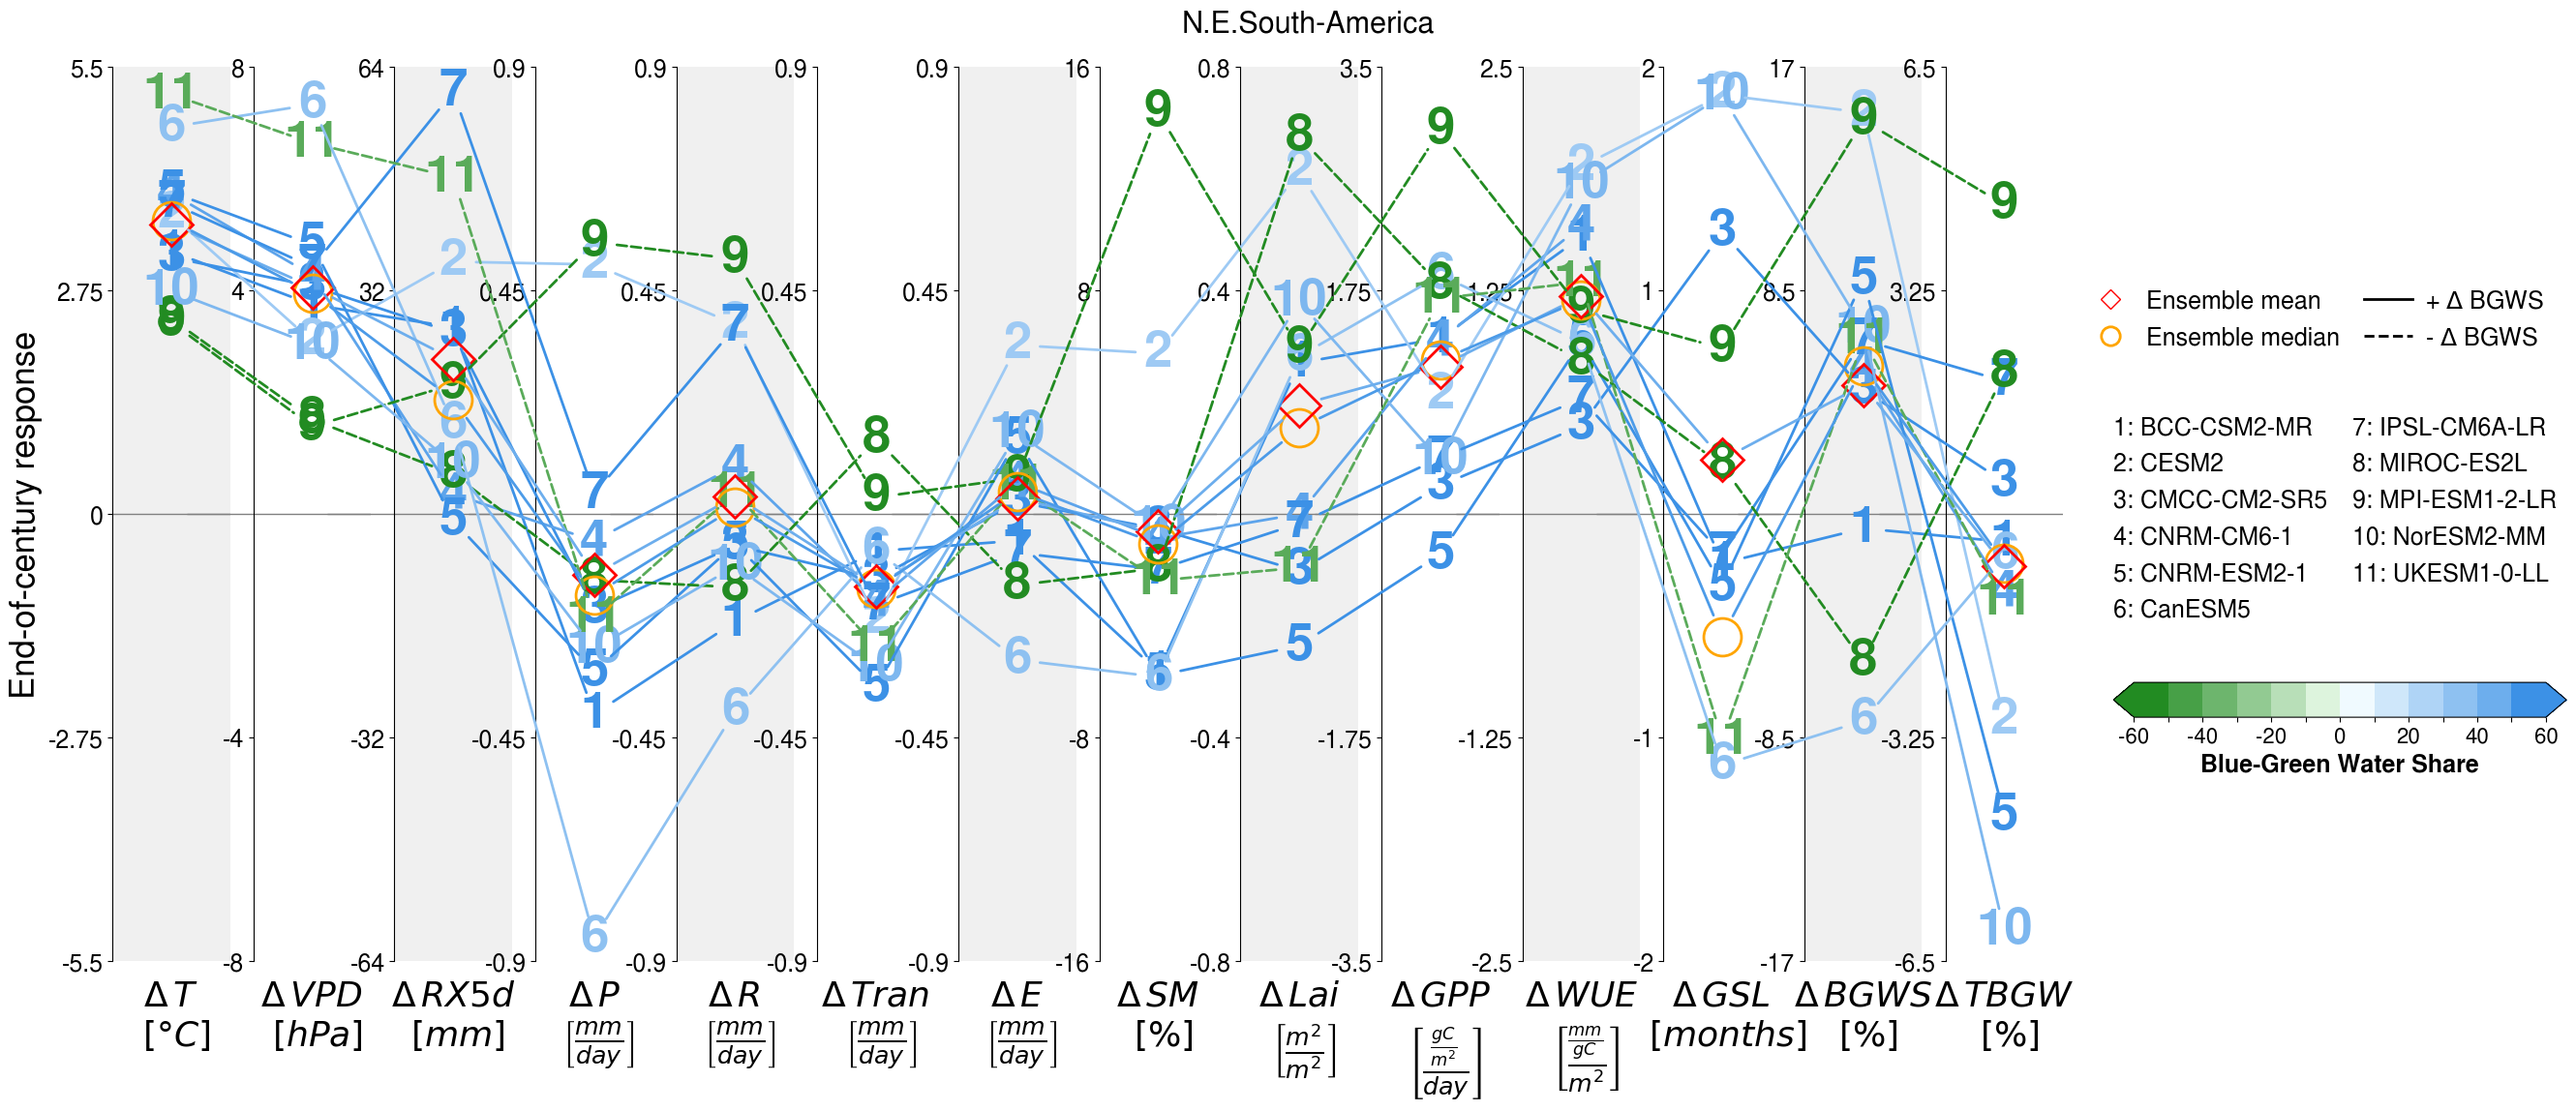

In [337]:
par_coor_plot.create_parallel_coordinate_plots(
                   ds_dict_change_region_mean['ssp370-historical'], 
                   ds_dict_region_mean['historical'],
                   selected_indices=[10] , # 'ALL' 
                   selected_vars=selected_variables, 
                   common_scale_for_mm_day=True,
                   legend=True,
                   save_fig=True,
                   subdiv=False,
                   yaxis_limits=None                        
                )

### Subregional Analysis

In [588]:
importlib.reload(par_coor_plot)

<module 'parallel_coordinate_plots' from '/work/ch0636/g300115/phd_project/common/src/visualization/parallel_coordinate_plots.py'>

In [591]:
region = 'EAS' # Global, ENA, NSA, CAF, WSAF, EAS, EAU

[14.549454600675947, 27.299788404473, 41.09833683061361, 28.562441273690748, 30.21693898064579, 26.081909180494563, 23.502952214049458, 22.031005961015605, 18.986958769544966, 22.06413091839242, 23.48072489253628, 21.261873072907573, 21.12638261066181]
Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/parallel_coordinate_plots/E.Asia/0_historical.pdf


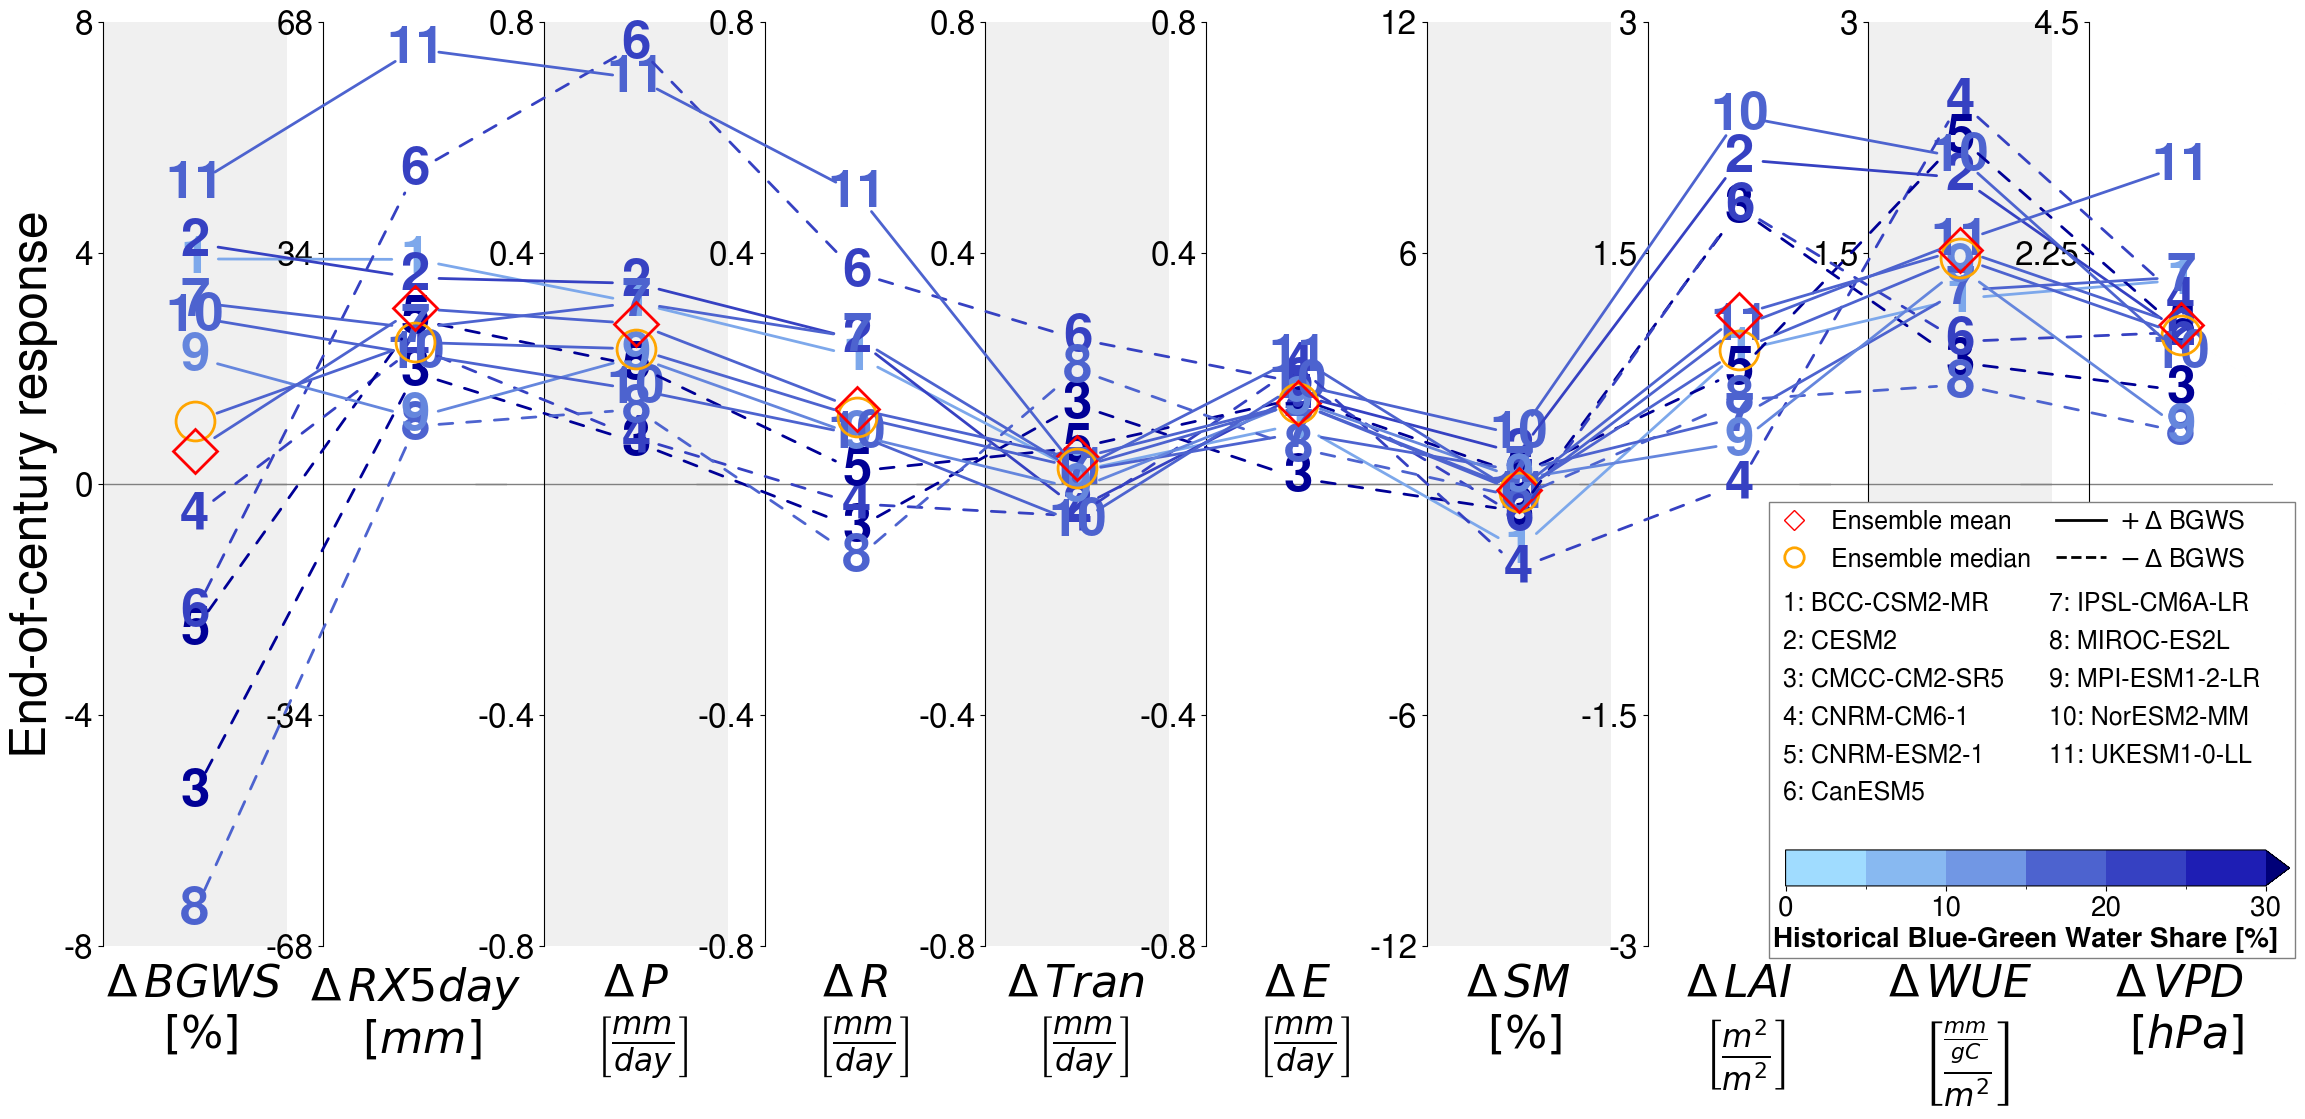

In [592]:
par_coor_plot.create_parallel_coordinate_plots(
                   ds_dict_change_region_sub_mean['ssp370-historical'], 
                   ds_dict_region_sub_mean['historical'], 
                   selected_indices=[colorbar_dict[region]['region_idx']],
                   selected_vars=selected_variables, 
                   common_scale_for_mm_day=False,
                   legend=True,
                   save_fig=True,
                   subdiv=True,
                   selected_subdiv_idx= colorbar_dict[region]['subdiv_idx'], # Global is both so set it yourself
                   yaxis_limits=colorbar_dict[region]['yaxis_limits']                        
                )     

In [593]:
region = 'Global' # Global, ENA, NSA, CAF, WSAF, EAS, EAU

[27.362685045964177, 27.532825941704626, 38.19373174644272, 24.575307929256994, 25.90135943890645, 28.894849661202418, 25.128212200550333, 18.093322906954423, 26.47140481243637, 27.859491866178193, 23.39057662206651, 22.94651427543922, 23.10846511141667]
Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/parallel_coordinate_plots/Global/0_historical.pdf


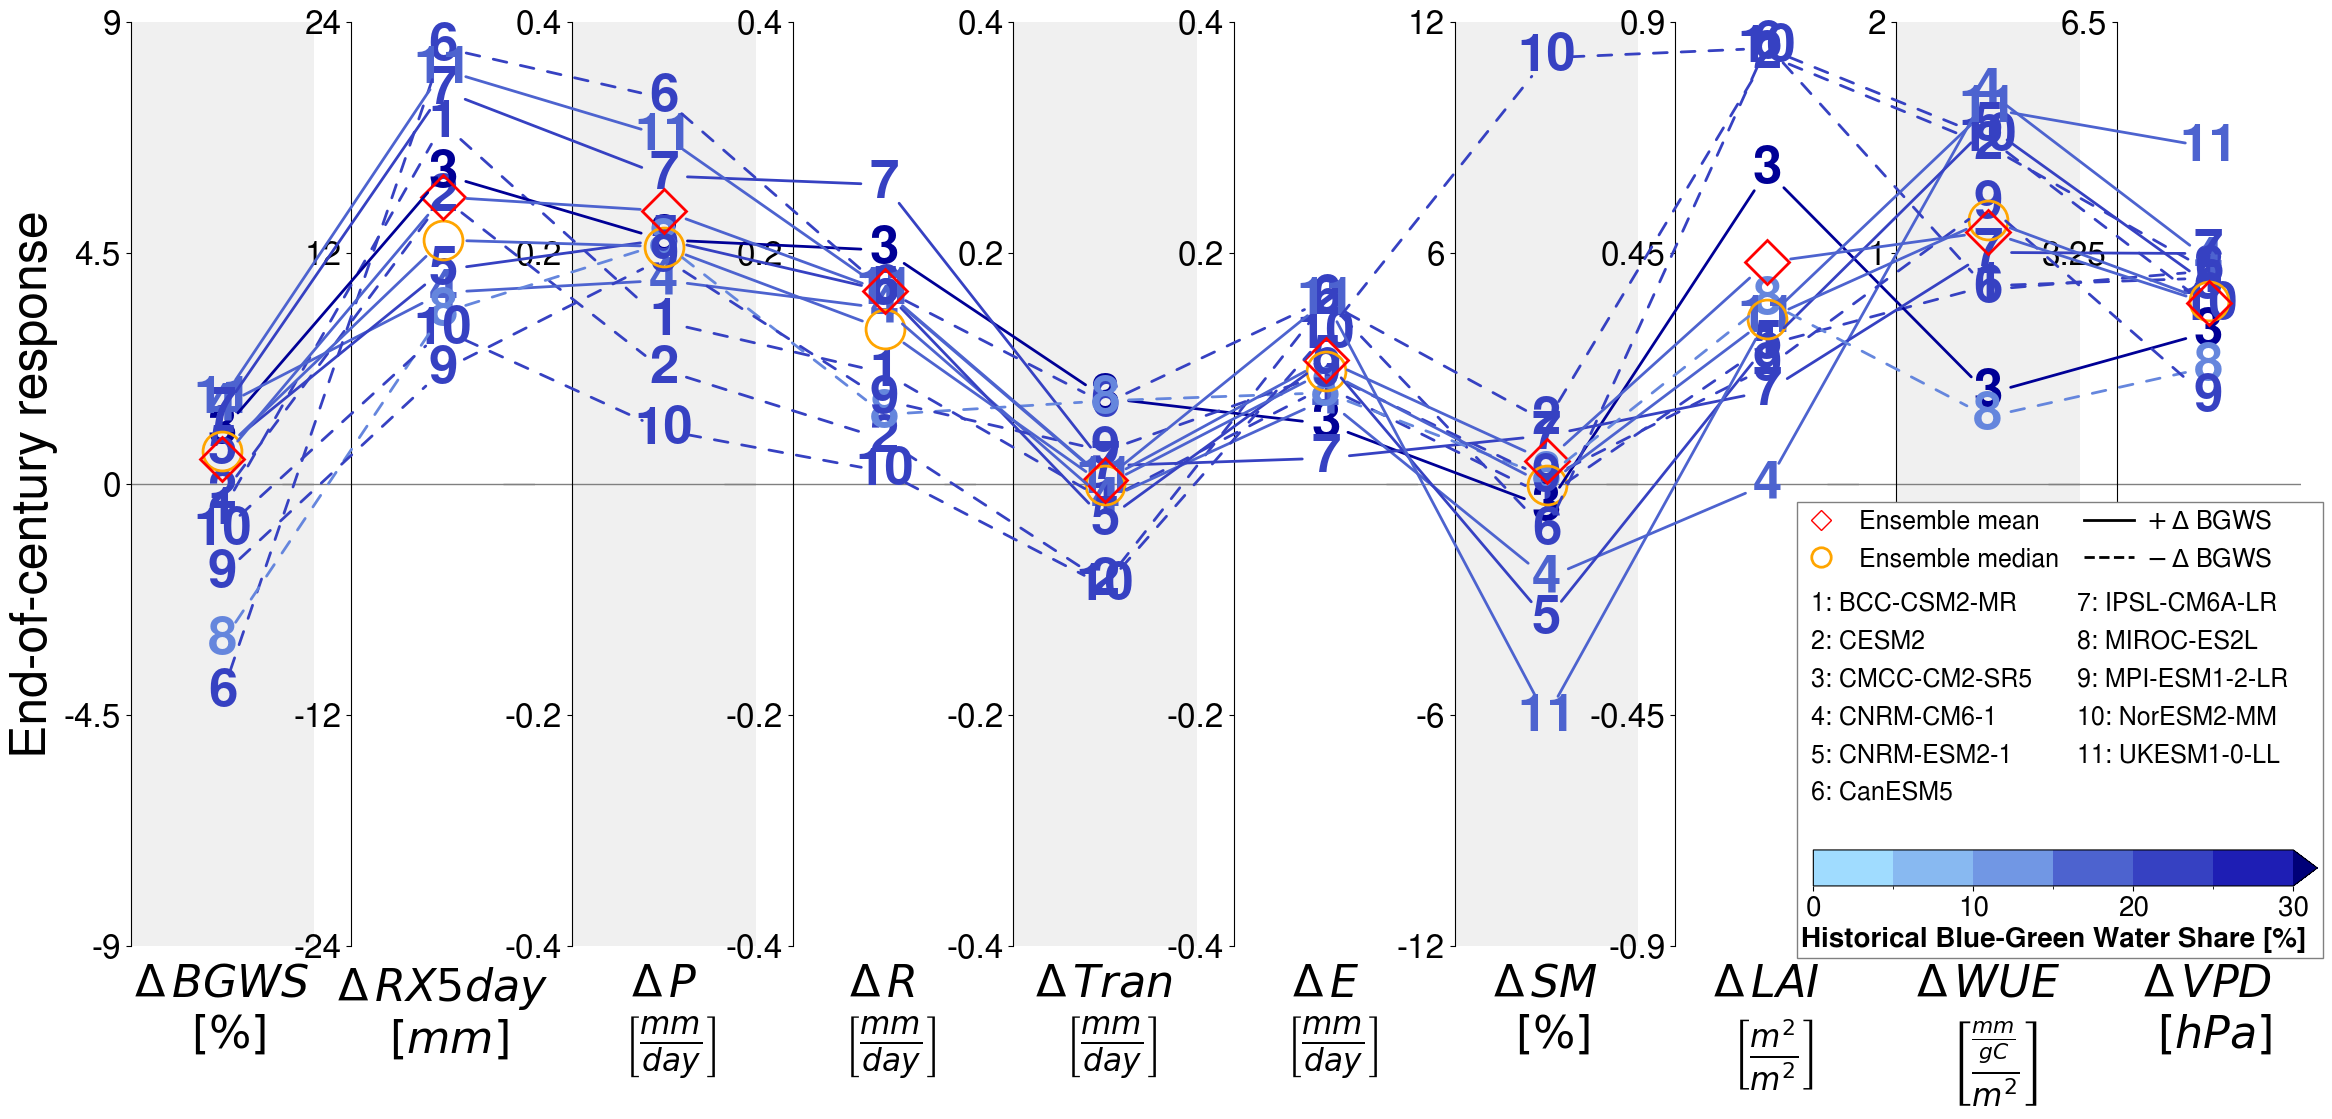

In [594]:
par_coor_plot.create_parallel_coordinate_plots(
                   ds_dict_change_region_sub_mean['ssp370-historical'], 
                   ds_dict_region_sub_mean['historical'], 
                   selected_indices=[colorbar_dict[region]['region_idx']],
                   selected_vars=selected_variables, 
                   common_scale_for_mm_day=False,
                   legend=True,
                   save_fig=True,
                   subdiv=True,
                   selected_subdiv_idx= 0, # Global is both so set it yourself
                   yaxis_limits=colorbar_dict[region]['yaxis_limits']                        
                )     